## Use Case: Improving Forecasting Models for Diverse Time Series

Imagine you're a data scientist participating in the M4 forecasting competition. Your tasks:
- Forecast diverse monthly time series for the next 18 months
- Provide reliable confidence intervals for these forecasts
- Assess the impact of different bootstrapping methods on forecast accuracy

Challenge: The M4 dataset contains 48,000 diverse time series, each with different patterns, trends, and seasonality.

Solution: Use time series bootstrapping to generate multiple plausible futures, improving forecast accuracy and uncertainty estimation across various types of time series.

By the end of this notebook, you'll be able to:
1. Apply various bootstrapping techniques to diverse time series data
2. Generate robust forecasts with confidence intervals for different types of series
3. Compare the performance of different bootstrapping methods on forecast accuracy

Let's begin our journey into time series bootstrapping with the M4 monthly dataset!


## 1. Introduction to Time Series Bootstrapping and the M4 Dataset

### What is it?
- Resampling technique for time-dependent data
- Respects chronological order and correlations
- Unlike traditional bootstrapping (assumes independence)

### Why is it important for the M4 competition?
- Estimate uncertainty in forecasts
- Generate confidence intervals
- Simulate alternative scenarios
- Improve model robustness

### Challenges with traditional methods
- Underestimates long-term variability
- Loses temporal dependence structure
- Incorrect inference on trends/seasonality

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import os
import pandas as pd

# Get the current working directory
current_dir = os.getcwd()

# Go back one level
parent_dir = os.path.dirname(current_dir)

# Construct the path to the m4.pkl file
file_path = os.path.join(parent_dir, 'm4_monthly_dataset.pkl')

# Load the file
data = pd.read_pickle(file_path)

# Print the data to verify
print(data)

                         value
series_name date              
T1          1976-06-01  8000.0
            1976-07-01  8350.0
            1976-08-01  8570.0
            1976-09-01  7700.0
            1976-10-01  7080.0
...                        ...
T48000      2015-12-31  5020.0
            2016-01-31  4950.0
            2016-02-29  4860.0
            2016-03-31  5140.0
            2016-04-30  5100.0

[11246411 rows x 1 columns]


In [23]:
import matplotlib.pyplot as plt

# Set universal matplotlib rc parameters
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (12, 15)

Number of time series: 48000
Date range: 1790-01-01 00:00:00 to 2224-04-30 00:00:00
Average series length: 234.30 months


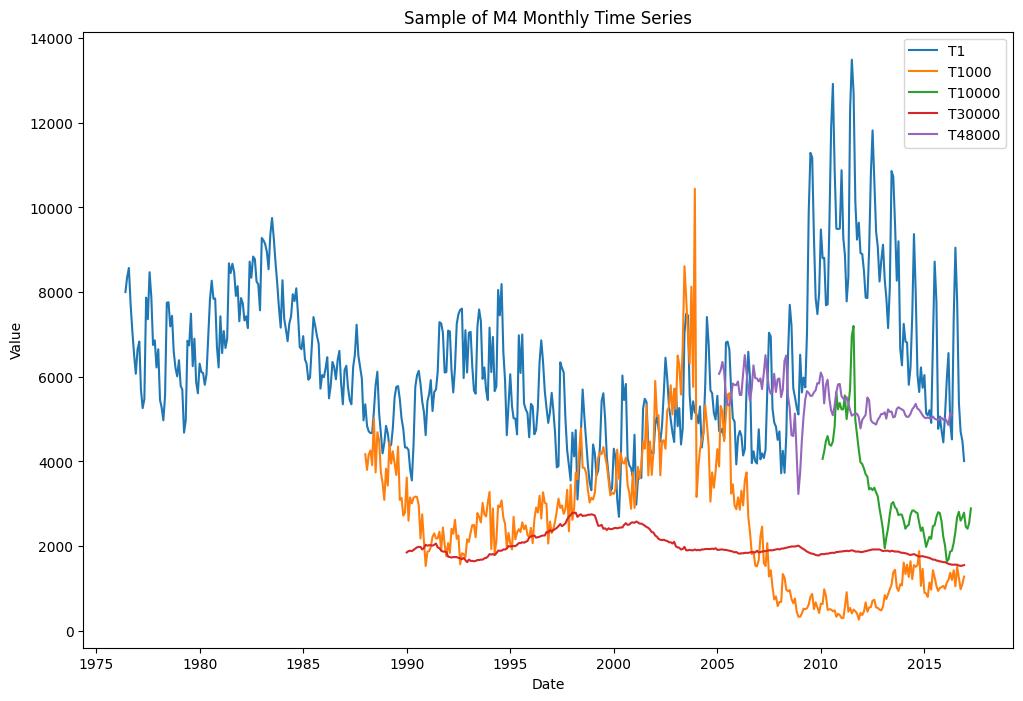

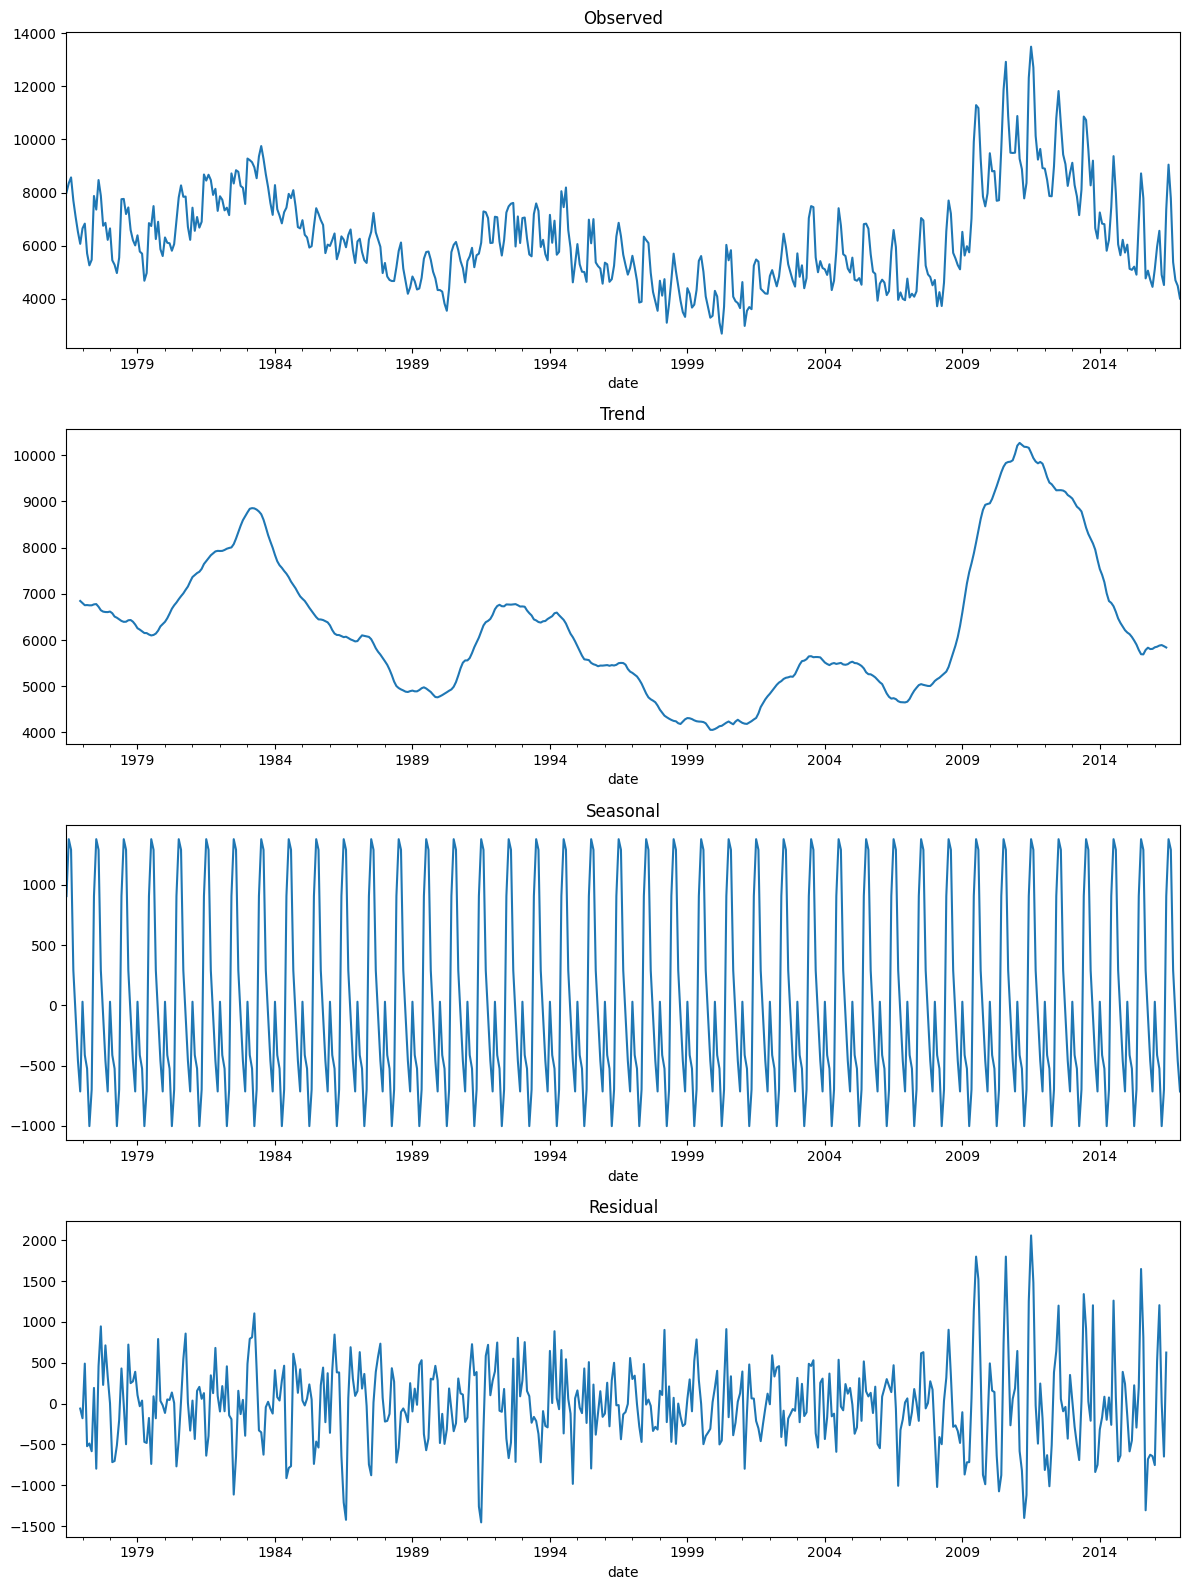

In [2]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Display basic information about the dataset
print(f"Number of time series: {
      data.index.get_level_values('series_name').nunique()}")
print(f"Date range: {data.index.get_level_values('date').min()} to {
      data.index.get_level_values('date').max()}")
print(f"Average series length: {data.groupby(
    'series_name').size().mean():.2f} months")

# Visualize a few diverse series
series_to_plot = ['T1', 'T1000', 'T10000', 'T30000', 'T48000']

plt.figure(figsize=(12, 8))
for series in series_to_plot:
    series_data = data.loc[series]
    plt.plot(series_data.index.get_level_values(
        'date'), series_data['value'], label=series)

plt.title('Sample of M4 Monthly Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Demonstrate seasonality in a sample series
# You might need to try different series to find one with clear seasonality
series_name = 'T1'
series = data.loc[series_name, 'value']

# Ensure the index is a DatetimeIndex
series.index = series.index.get_level_values('date')

result = seasonal_decompose(series, model='additive', period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
result.observed.plot(ax=ax1)
ax1.set_title('Observed')
result.trend.plot(ax=ax2)
ax2.set_title('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

## 2. Bootstrapping

### Overview
- Resampling technique
- Estimates sample statistic distribution
- Draws samples with replacement
- No strict distribution assumptions

```mermaid
%%{init: {
  "theme": "default",
  "themeVariables": {
    "primaryColor": "#3498db",
    "primaryTextColor": "#ffffff",
    "primaryBorderColor": "#2980b9",
    "lineColor": "#34495e",
    "secondaryColor": "#2ecc71",
    "tertiaryColor": "#e74c3c",
    "tertiaryTextColor": "#ffffff",
    "tertiaryBorderColor": "#c0392b",
    "fontFamily": "Arial, sans-serif",
    "fontSize": "18px",
    "noteBkgColor": "#f5f5f5",
    "noteTextColor": "#333",
    "noteBorderColor": "#ddd",
    "edgeLabelBackground": "#ffffff"
  },
  "flowchart": {
    "nodeSpacing": 10,
    "rankSpacing": 30,
    "curve": "basis",
    "lineWidth": 2,
    "arrowMarkerAbsolute": true
  }
}}%%

graph LR
    A[Original Data] --> B[Resample with Replacement]
    B --> C[Calculate Statistic]
    C --> D{Repeat N times?}
    D -->|Yes| B
    D -->|No| E[Distribution of Statistic]
    E --> F[Inference]


### Key Aspects
1. Model-Free Inference
   - Non-parametric
   - For unknown/complex distributions

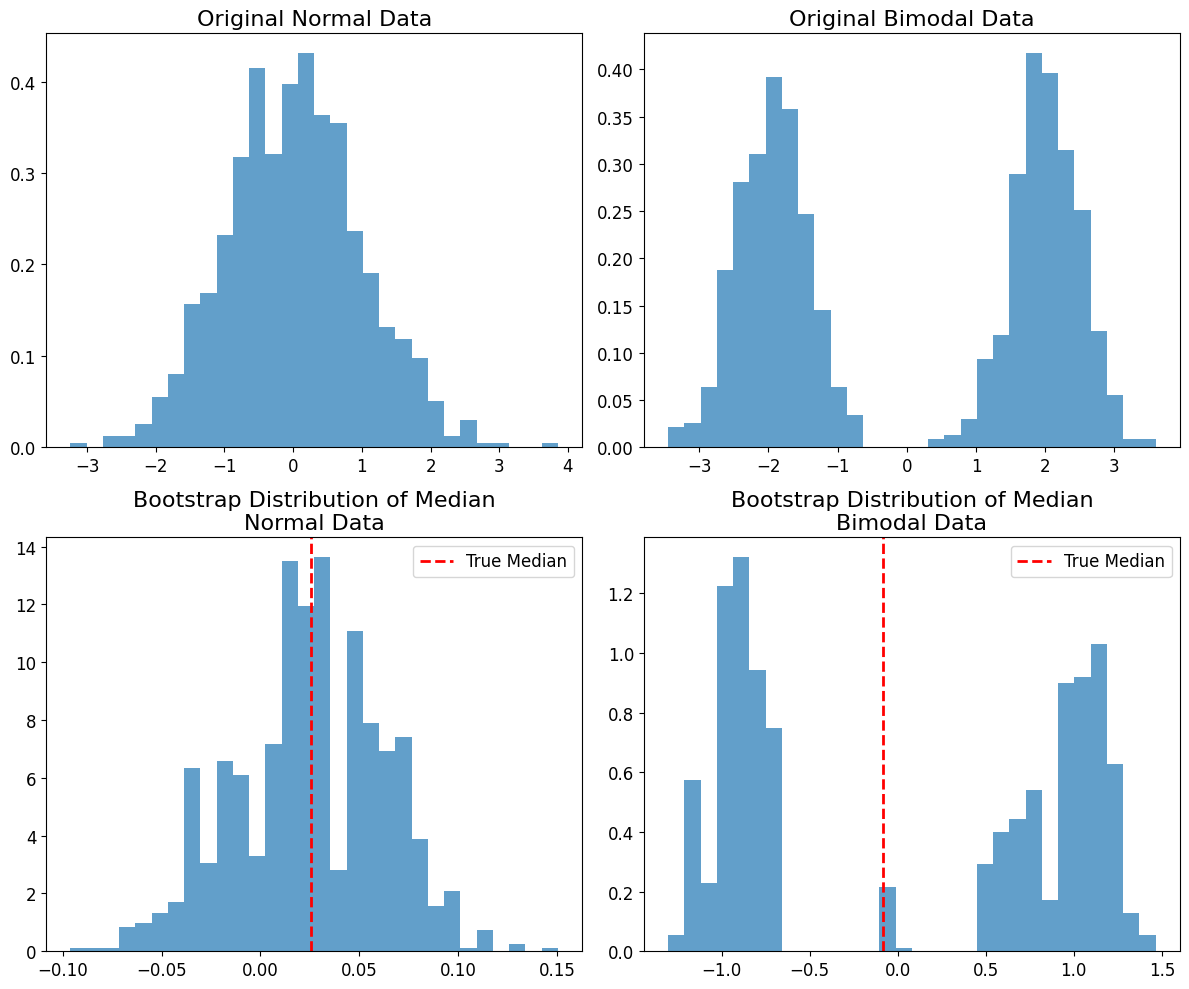

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

# Generate data
normal_data = np.random.normal(0, 1, 1000)
bimodal_data = np.concatenate(
    [np.random.normal(-2, 0.5, 500), np.random.normal(2, 0.5, 500)])


def bootstrap_median(data, n_bootstrap=1000):
    medians = np.zeros(n_bootstrap)
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        medians[i] = np.median(sample)
    return medians


# Perform bootstrap
normal_bootstrap = bootstrap_median(normal_data)
bimodal_bootstrap = bootstrap_median(bimodal_data)

# Create plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Normal distribution
ax1.hist(normal_data, bins=30, density=True, alpha=0.7)
ax1.set_title('Original Normal Data')

ax3.hist(normal_bootstrap, bins=30, density=True, alpha=0.7)
ax3.axvline(np.median(normal_data), color='r',
            linestyle='dashed', label='True Median')
ax3.set_title('Bootstrap Distribution of Median\nNormal Data')
ax3.legend()

# Bimodal distribution
ax2.hist(bimodal_data, bins=30, density=True, alpha=0.7)
ax2.set_title('Original Bimodal Data')

ax4.hist(bimodal_bootstrap, bins=30, density=True, alpha=0.7)
ax4.axvline(np.median(bimodal_data), color='r',
            linestyle='dashed', label='True Median')
ax4.set_title('Bootstrap Distribution of Median\nBimodal Data')
ax4.legend()

plt.tight_layout()
plt.show()

- Uncertainty Assessment
  - Estimates confidence intervals, standard errors

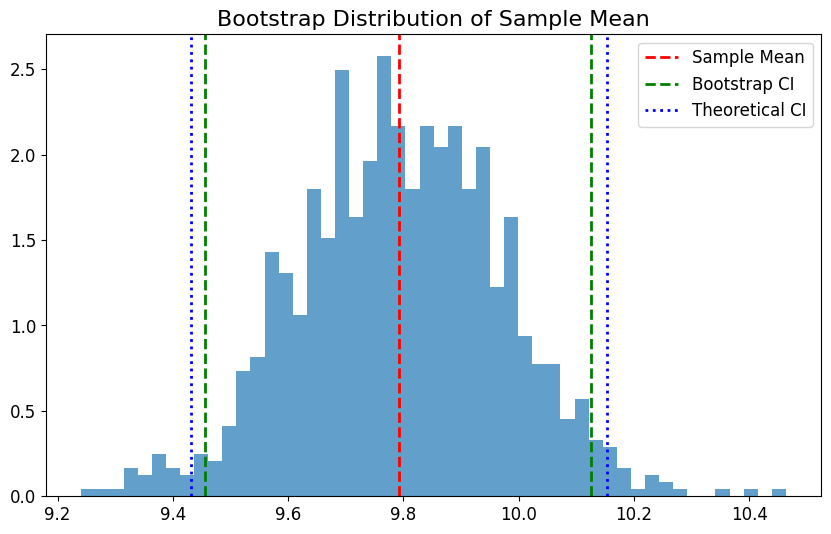

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate sample data
np.random.seed(42)
data = np.random.normal(10, 2, 100)

# Bootstrap
n_bootstrap = 1000
bootstrap_means = np.zeros(n_bootstrap)
for i in range(n_bootstrap):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    bootstrap_means[i] = np.mean(bootstrap_sample)

# Calculate confidence intervals
sample_mean = np.mean(data)
bootstrap_ci = np.percentile(bootstrap_means, [2.5, 97.5])
theoretical_ci = stats.t.interval(
    0.95, len(data)-1, loc=sample_mean, scale=stats.sem(data))

# Plot
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means, bins=50, density=True, alpha=0.7)
plt.axvline(sample_mean, color='r', linestyle='dashed',
            linewidth=2, label='Sample Mean')
plt.axvline(bootstrap_ci[0], color='g',
            linestyle='dashed', linewidth=2, label='Bootstrap CI')
plt.axvline(bootstrap_ci[1], color='g', linestyle='dashed', linewidth=2)
plt.axvline(theoretical_ci[0], color='b',
            linestyle='dotted', linewidth=2, label='Theoretical CI')
plt.axvline(theoretical_ci[1], color='b', linestyle='dotted', linewidth=2)
plt.title('Bootstrap Distribution of Sample Mean')
plt.legend()
plt.show()

- Model Validation
  - Assesses model stability, reliability

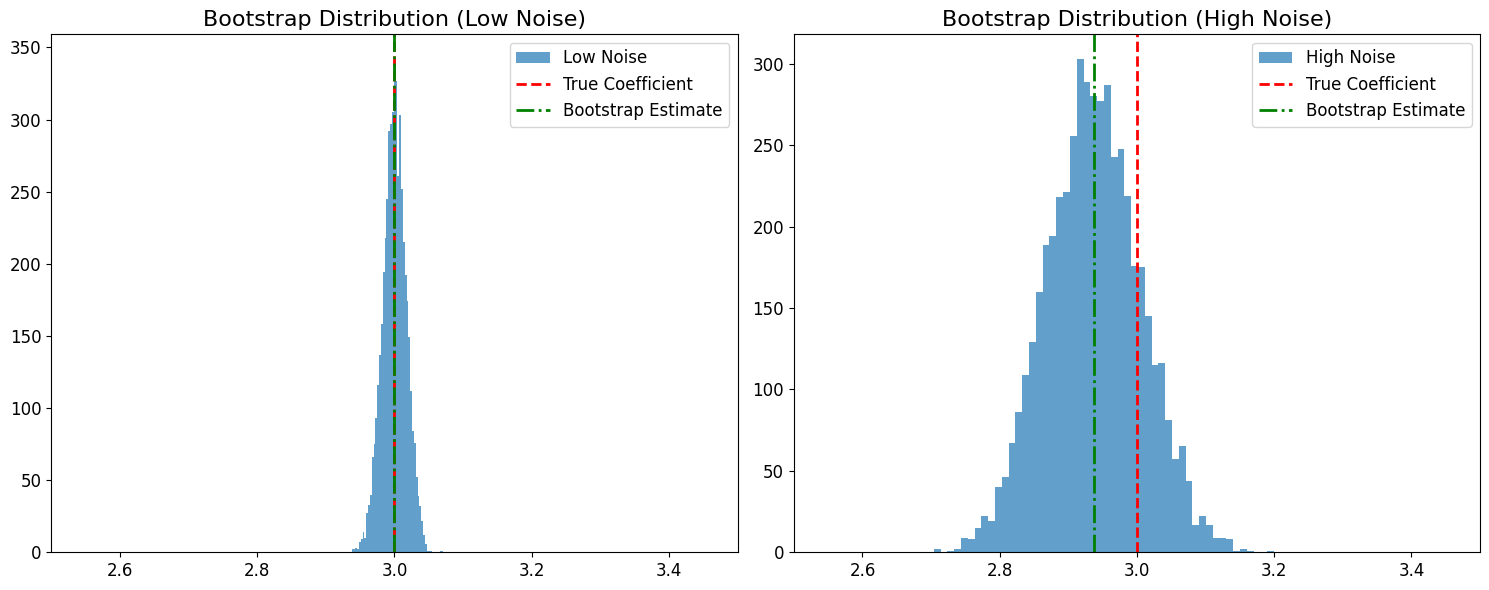

Low Noise - Bootstrap Estimate: 2.9999, True Value: 3.0000
High Noise - Bootstrap Estimate: 2.9369, True Value: 3.0000
Low Noise - Std Dev: 0.0172
High Noise - Std Dev: 0.0688


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def generate_data(n, noise_level):
    X = np.random.rand(n, 1)
    y = 2 + 3 * X + np.random.randn(n, 1) * noise_level
    return X, y


def bootstrap_coef(X, y, n_bootstrap=5000):
    coefs = np.zeros(n_bootstrap)
    for i in range(n_bootstrap):
        indices = np.random.randint(0, len(X), len(X))
        X_boot, y_boot = X[indices], y[indices]
        model = LinearRegression().fit(X_boot, y_boot)
        coefs[i] = model.coef_[0]
    return coefs


# Parameters
np.random.seed(42)  # for reproducibility
n_points = 1000
n_simulations = 10
low_noise = 0.5
high_noise = 2.0

# Run multiple simulations
low_noise_coefs = []
high_noise_coefs = []

for _ in range(n_simulations):
    X_low, y_low = generate_data(n_points, low_noise)
    X_high, y_high = generate_data(n_points, high_noise)

    low_noise_coefs.append(bootstrap_coef(X_low, y_low))
    high_noise_coefs.append(bootstrap_coef(X_high, y_high))

# Average the results
low_noise_avg = np.mean(low_noise_coefs, axis=0)
high_noise_avg = np.mean(high_noise_coefs, axis=0)

# Calculate bootstrap estimates
low_noise_estimate = np.mean(low_noise_avg)
high_noise_estimate = np.mean(high_noise_avg)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(low_noise_avg, bins=50, alpha=0.7, label='Low Noise')
ax1.axvline(3, color='r', linestyle='dashed', label='True Coefficient')
ax1.axvline(low_noise_estimate, color='g',
            linestyle='dashdot', label='Bootstrap Estimate')
ax1.set_title('Bootstrap Distribution (Low Noise)')
ax1.legend()
ax1.set_xlim(2.5, 3.5)

ax2.hist(high_noise_avg, bins=50, alpha=0.7, label='High Noise')
ax2.axvline(3, color='r', linestyle='dashed', label='True Coefficient')
ax2.axvline(high_noise_estimate, color='g',
            linestyle='dashdot', label='Bootstrap Estimate')
ax2.set_title('Bootstrap Distribution (High Noise)')
ax2.legend()
ax2.set_xlim(2.5, 3.5)

plt.tight_layout()
plt.show()

# Print summary statistics
print(
    f"Low Noise - Bootstrap Estimate: {low_noise_estimate:.4f}, True Value: 3.0000")
print(
    f"High Noise - Bootstrap Estimate: {high_noise_estimate:.4f}, True Value: 3.0000")
print(f"Low Noise - Std Dev: {np.std(low_noise_avg):.4f}")
print(f"High Noise - Std Dev: {np.std(high_noise_avg):.4f}")

- Complex Estimators
  - Empirical distribution examination

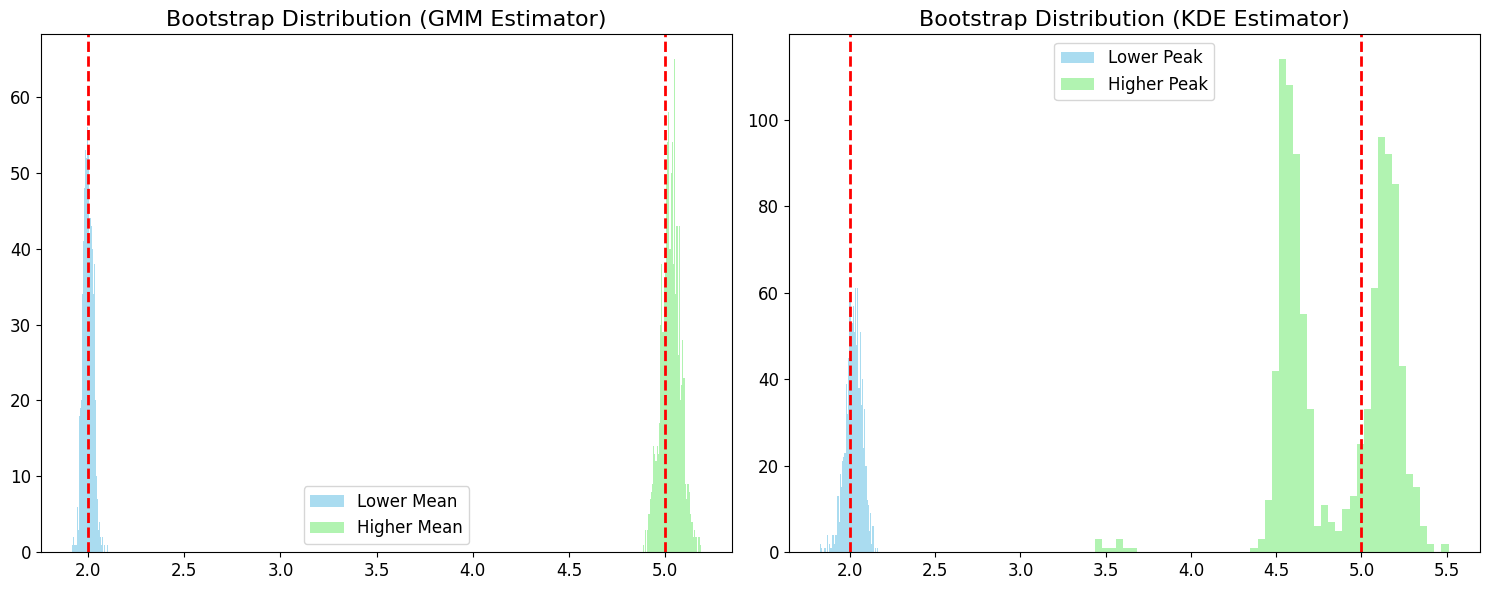

GMM Estimator:
Lower Mean - Bootstrap Median: 1.9988, True Value: 2.0000
Higher Mean - Bootstrap Median: 5.0292, True Value: 5.0000

KDE Estimator:
Lower Peak - Bootstrap Median: 2.0244, True Value: 2.0000
Higher Peak - Bootstrap Median: 4.8938, True Value: 5.0000


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity


def bootstrap_complex_estimators(data, n_bootstrap=1000):
    gmm_estimates = []
    kde_estimates = []
    n = len(data)

    for _ in range(n_bootstrap):
        boot_sample = np.random.choice(data, size=n, replace=True)

        # GMM estimator
        gmm = GaussianMixture(n_components=2, random_state=42)
        gmm.fit(boot_sample.reshape(-1, 1))
        gmm_estimates.append(np.sort(gmm.means_.flatten())
                             )  # Store both means, sorted

        # KDE estimator
        kde = KernelDensity(kernel='gaussian', bandwidth='scott').fit(
            boot_sample.reshape(-1, 1))
        x_range = np.linspace(
            boot_sample.min(), boot_sample.max(), 1000).reshape(-1, 1)
        kde_density = np.exp(kde.score_samples(x_range))
        peaks = x_range[np.r_[True, kde_density[1:] > kde_density[:-1]] &
                        np.r_[kde_density[:-1] > kde_density[1:], True]].flatten()
        # Store the two most prominent peaks
        kde_estimates.append(np.sort(peaks)[:2])

    return np.array(gmm_estimates), np.array(kde_estimates)


# Generate some complex data
np.random.seed(42)
data = np.concatenate([
    np.random.normal(loc=2, scale=0.5, size=500),
    np.random.normal(loc=5, scale=1, size=500)
])

# Perform bootstrap
gmm_estimates, kde_estimates = bootstrap_complex_estimators(data)

# True values
true_values = [2, 5]  # The two means used in data generation

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(gmm_estimates[:, 0], bins=50, alpha=0.7,
         color='skyblue', label='Lower Mean')
ax1.hist(gmm_estimates[:, 1], bins=50, alpha=0.7,
         color='lightgreen', label='Higher Mean')
for tv in true_values:
    ax1.axvline(tv, color='r', linestyle='dashed')
ax1.set_title('Bootstrap Distribution (GMM Estimator)')
ax1.legend()

ax2.hist(kde_estimates[:, 0], bins=50, alpha=0.7,
         color='skyblue', label='Lower Peak')
ax2.hist(kde_estimates[:, 1], bins=50, alpha=0.7,
         color='lightgreen', label='Higher Peak')
for tv in true_values:
    ax2.axvline(tv, color='r', linestyle='dashed')
ax2.set_title('Bootstrap Distribution (KDE Estimator)')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("GMM Estimator:")
print(f"Lower Mean - Bootstrap Median: {np.median(
    gmm_estimates[:, 0]):.4f}, True Value: {true_values[0]:.4f}")
print(f"Higher Mean - Bootstrap Median: {np.median(
    gmm_estimates[:, 1]):.4f}, True Value: {true_values[1]:.4f}")
print("\nKDE Estimator:")
print(f"Lower Peak - Bootstrap Median: {np.median(
    kde_estimates[:, 0]):.4f}, True Value: {true_values[0]:.4f}")
print(f"Higher Peak - Bootstrap Median: {np.median(
    kde_estimates[:, 1]):.4f}, True Value: {true_values[1]:.4f}")



### Time Series Challenges
- IID bootstrapping unsuitable
- Must respect temporal structure
- Specialized methods needed

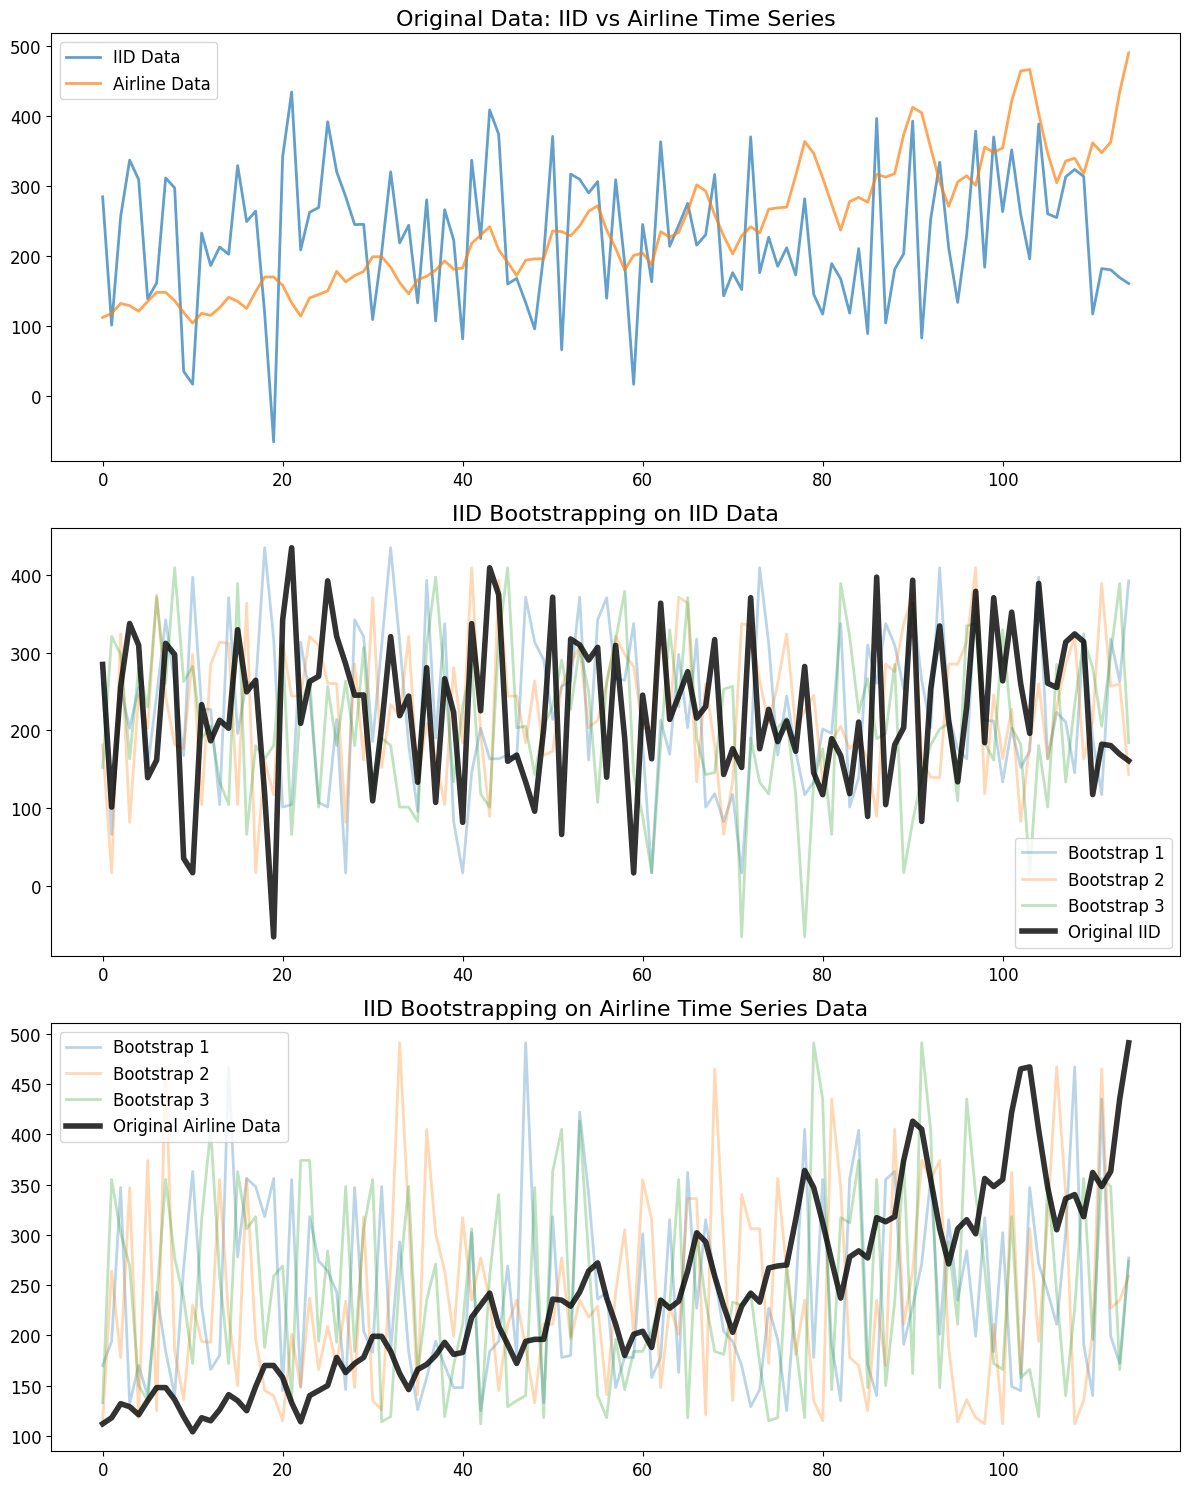

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split

# Set universal matplotlib rc parameters
# Set universal matplotlib rc parameters
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (12, 15)

# Load the airline dataset
y = load_airline()

# Split the data into train and test sets
y_train, y_test = temporal_train_test_split(y, test_size=0.2)

# Convert to numpy array for easier manipulation
ts_data = y_train.values

# Generate IID data with similar properties to the airline data
iid_data = np.random.normal(ts_data.mean(), ts_data.std(), len(ts_data))

# Set random seed for reproducibility
np.random.seed(42)

# Create the plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Plot 1: Original Data
ax1.plot(iid_data, label='IID Data', alpha=0.7)
ax1.plot(ts_data, label='Airline Data', alpha=0.7)
ax1.set_title('Original Data: IID vs Airline Time Series')
ax1.legend()

# Plot 2: IID Bootstrapping on IID Data
for i in range(3):
    bootstrap_iid = np.random.choice(
        iid_data, size=len(iid_data), replace=True)
    ax2.plot(bootstrap_iid, label=f'Bootstrap {i+1}', alpha=0.3)
ax2.plot(iid_data, label='Original IID', color='black', linewidth=4, alpha=0.8)
ax2.set_title('IID Bootstrapping on IID Data')
ax2.legend()

# Plot 3: IID Bootstrapping on Time Series Data
for i in range(3):
    bootstrap_ts = np.random.choice(ts_data, size=len(ts_data), replace=True)
    ax3.plot(bootstrap_ts, label=f'Bootstrap {i+1}', alpha=0.3)
ax3.plot(ts_data, label='Original Airline Data',
         color='black', linewidth=4, alpha=0.8)
ax3.set_title('IID Bootstrapping on Airline Time Series Data')
ax3.legend()

plt.tight_layout()
plt.show()


## 2. `tsbootstrap`: Your Toolkit for Time Series Resampling

### Project Goals:
- Unified, sklearn-like interface
- Flexible block length handling
- Support univariate/multivariate series
- Integrate with libraries like sktime

### Key Features:

1. **Block Bootstrap Methods:**
   - Moving
   - Circular
   - Stationary
   - Non-Overlapping

2. **Window-based Methods:**
   - Bartlett
   - Blackman
   - Hamming
   - Hanning
   - Tukey

3. **Model-based Methods:**
   - Residual
   - Distribution
   - Markov
   - Sieve

4. **Statistic-Preserving Bootstrap**

5. **Customizable:**
   - Block length sampling
   - Block generation

```mermaid
%%{init: {
  "theme": "default",
  "themeVariables": {
    "primaryColor": "#3498db",
    "primaryTextColor": "#ffffff",
    "primaryBorderColor": "#2980b9",
    "lineColor": "#34495e",
    "secondaryColor": "#2ecc71",
    "tertiaryColor": "#e74c3c",
    "tertiaryTextColor": "#ffffff",
    "tertiaryBorderColor": "#c0392b",
    "fontFamily": "Arial, sans-serif",
    "fontSize": "18px",
    "noteBkgColor": "#f5f5f5",
    "noteTextColor": "#333",
    "noteBorderColor": "#ddd",
    "edgeLabelBackground": "#ffffff"
  },
  "flowchart": {
    "nodeSpacing": 10,
    "rankSpacing": 30,
    "curve": "basis",
    "lineWidth": 2,
    "arrowMarkerAbsolute": true
  }
}}%%

graph LR
    %% Define styles
    classDef green fill:#90EE90,stroke:#333,stroke-width:2px;
    classDef orange fill:#FFA500,stroke:#333,stroke-width:2px;
    classDef blue fill:#87CEFA,stroke:#333,stroke-width:2px;
    classDef gray fill:#D3D3D3,stroke:#333,stroke-width:2px;

    %% Legend
    subgraph Legend
        L1[Base Class]:::green
        L2[Intermediate Class]:::orange
        L3[Specific Method]:::blue
        L4[Utility Class]:::gray
    end

    %% The rest of the diagram content remains the same as in the previous version

    %% Top row
    BaseStatisticPreserving[BaseStatisticPreserving]:::orange
    TimeSeriesModel[TimeSeriesModel]:::gray

    %% Second row
    WholeStatisticPreserving[WholeStatisticPreserving]:::blue
    BlockStatisticPreserving[BlockStatisticPreserving]:::blue
    TSFit[TSFit]:::gray
    RankLags[RankLags]:::gray

    %% Third row
    TSFitBestLag[TSFitBestLag]:::gray
    BaseTimeSeries[BaseTimeSeries]:::green

    %% Fourth row
    BaseResidual[BaseResidual]:::orange
    BaseStatisticPreserving2[BaseStatisticPreserving]:::orange
    Block[Block]:::orange
    BlockGenerator[BlockGenerator]:::gray
    BlockLengthSampler[BlockLengthSampler]:::gray
    BlockResampler[BlockResampler]:::gray

    %% Fifth row
    BaseDistribution[BaseDistribution]:::blue
    WholeResidual[WholeResidual]:::blue
    BaseMarkov[BaseMarkov]:::blue
    BlockResidual[BlockResidual]:::blue
    BlockCompressor[BlockCompressor]:::gray
    MarkovTransitionMatrixCalculator[MarkovTransitionMatrixCalculator]:::gray
    BaseSieve[BaseSieve]:::blue
    CircularBlock[CircularBlock]:::blue
    MovingBlock[MovingBlock]:::blue
    BaseBlock[BaseBlock]:::blue
    Stationary[Stationary]:::blue
    NonOverlappingBlock[NonOverlappingBlock]:::blue

    %% Sixth row
    WholeDistribution[WholeDistribution]:::blue
    BlockDistribution[BlockDistribution]:::blue
    WholeMarkov[WholeMarkov]:::blue
    BlockMarkov[BlockMarkov]:::blue
    MarkovSampler[MarkovSampler]:::gray
    WholeSieve[WholeSieve]:::blue
    BlockSieve[BlockSieve]:::blue
    Blackman[Blackman]:::blue
    Hamming[Hamming]:::blue
    Hanning[Hanning]:::blue
    Tukey[Tukey]:::blue
    Bartletts[Bartletts]:::blue

    %% Connections
    BaseStatisticPreserving --> WholeStatisticPreserving
    BaseStatisticPreserving --> BlockStatisticPreserving
    TimeSeriesModel --> TSFit
    TSFit --> TSFitBestLag
    RankLags -.-> TSFitBestLag
    TSFitBestLag -.-> BaseResidual
    BaseTimeSeries --> BaseResidual
    BaseTimeSeries --> BaseStatisticPreserving2
    BaseTimeSeries --> Block
    BaseResidual --> BaseDistribution
    BaseResidual --> WholeResidual
    BaseResidual --> BaseMarkov
    BaseResidual --> BlockResidual
    BaseResidual --> BaseSieve
    BlockGenerator -.-> Block
    BlockLengthSampler -.-> Block
    BlockResampler -.-> Block
    BaseDistribution --> WholeDistribution
    BaseDistribution --> BlockDistribution
    BaseMarkov --> WholeMarkov
    BaseMarkov --> BlockMarkov
    BlockCompressor -.-> MarkovSampler
    MarkovTransitionMatrixCalculator -.-> MarkovSampler
    MarkovSampler -.-> WholeMarkov
    MarkovSampler -.-> BlockMarkov
    BaseSieve --> WholeSieve
    BaseSieve --> BlockSieve
    Block --> CircularBlock
    Block --> MovingBlock
    Block --> BaseBlock
    Block --> Stationary
    Block --> NonOverlappingBlock
    BaseBlock --> Blackman
    BaseBlock --> Hamming
    BaseBlock --> Hanning
    BaseBlock --> Tukey
    BaseBlock --> Bartletts
```

| Bootstrapping Method | Class (...`Bootstrap`) | Salient Features |
|----------------------|------------------------|-------------------|
| Moving Block | `MovingBlock` | Suitable for series with significant intra-block dependencies; avoid for weak dependencies |
| Circular Block | `CircularBlock` | Ideal for seasonal/cyclical data; not recommended for non-cyclical data |
| Stationary | `StationaryBlock` | Best for data with varying dependency lengths; less effective for uniform dependency lengths |
| Non-Overlapping Block | `NonOverlappingBlock` | Effective for data with distinct segments; not suitable for continuous or highly dependent data |
| Tapered Block | `Bartletts`, `Hamming`, `Blackman`, `Tukey` | Mitigates edge effects using window functions; requires matching window functions to data characteristics |
| Residual | `WholeResidual`, `BlockResidual` | Evaluates model-based uncertainty; not intended for non-model analyses |
| Statistic-Preserving | `WholeStatisticPreserving`, `BlockStatisticPreserving` | Maintains key statistical properties; not for general purposes without specific preservation needs |
| Distribution | `WholeDistribution`, `BlockDistribution` | Leverages known distributions; inappropriate for unknown distributions |
| Markov | `WholeMarkov`, `BlockMarkov` | Suitable for Markovian time series; avoid for non-Markovian series |
| Sieve | `WholeSieve`, `BlockSieve` | Designed for autoregressive models; not recommended for non-autoregressive series |

Table: Overview of bootstrapping classes in `tsbootstrap`.

In [31]:
data = pd.read_pickle(file_path)

In [51]:
# Select a single series
series_name = 'T1'
single_series = data.loc[series_name]['value']

# Split into train and test sets
train_size = int(len(single_series) * 0.8)
train, test = single_series[:train_size], single_series[train_size:]

print(f"Train set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

Train set shape: (389,)
Test set shape: (98,)


In [52]:
train = train.values
test = test.values

In [53]:
from tsbootstrap import MovingBlockBootstrap, CircularBlockBootstrap
import numpy as np

np.random.seed(42)
n_bootstraps = 1000

mbb = MovingBlockBootstrap(n_bootstraps=n_bootstraps, block_length=12)
cbb = CircularBlockBootstrap(n_bootstraps=n_bootstraps, block_length=12)

mbb_samples = mbb.bootstrap(train)
cbb_samples = cbb.bootstrap(train)

# Function to count and get shape of generator items
def get_generator_info(generator):
    samples = list(generator)
    count = len(samples)
    if count > 0:
        shape = (count,) + np.shape(samples[0])
    else:
        shape = (0,)
    return count, shape


# Get info for MBB samples
mbb_count, mbb_shape = get_generator_info(mbb_samples)
print(f"MBB samples count: {mbb_count}")
print(f"MBB samples shape: {mbb_shape}")

# Recreate the generator for CBB samples
cbb_samples = cbb.bootstrap(train)

# Get info for CBB samples
cbb_count, cbb_shape = get_generator_info(cbb_samples)
print(f"CBB samples count: {cbb_count}")
print(f"CBB samples shape: {cbb_shape}")

[8000. 8350. 8570. 7700. 7080. 6520. 6070. 6650. 6830. 5710. 5260. 5470.
 7870. 7360. 8470. 7880. 6750. 6860. 6220. 6650. 5450. 5280. 4970. 5550.
 7750. 7760. 7190. 7440. 6590. 6210. 6010. 6390. 5780. 5700. 4680. 4970.
 6850. 6740. 7490. 6250. 6900. 5870. 5610. 6310. 6110. 6090. 5810. 6060.
 6950. 7820. 8270. 7840. 7850. 6710. 6220. 7430. 6560. 7080. 6680. 6900.
 8680. 8450. 8670. 8470. 7910. 8140. 7310. 7860. 7730. 7330. 7430. 7150.
 8720. 8340. 8840. 8780. 8250. 8180. 7570. 9280. 9220. 9140. 8950. 8540.
 9360. 9750. 9270. 8690. 8200. 7610. 7160. 8280. 7370. 7130. 6840. 7260.
 7430. 7950. 7790. 8090. 7480. 6700. 6650. 6960. 6410. 6310. 5930. 5980.
 6730. 7410. 7200. 6960. 6780. 5720. 6040. 5990. 6210. 6460. 5490. 5790.
 6350. 6230. 5940. 6400. 6610. 5840. 5350. 6160. 6260. 5760. 5450. 5350.
 6230. 6520. 7230. 6500. 6230. 5960. 4970. 5350. 4840. 4710. 4670. 4670.
 5190. 5800. 6120. 5140. 4670. 4190. 4430. 4840. 4660. 4350. 4390. 4790.
 5510. 5760. 5780. 5470. 5020. 4770. 4330. 4330. 42

In [54]:
from sktime.forecasting.naive import NaiveForecaster
import numpy as np
import pandas as pd


def generate_forecast_with_ci(train_series, bootstrap_samples, horizon):
    forecaster = NaiveForecaster(strategy="last")
    train_series_pd = pd.Series(train_series.ravel())
    forecaster.fit(train_series_pd)
    point_forecast = forecaster.predict(fh=np.arange(1, horizon + 1))

    bootstrap_forecasts = []
    for sample in bootstrap_samples:
        sample_forecast = forecaster.fit(
            pd.Series(sample.ravel())).predict(fh=np.arange(1, horizon + 1))
        bootstrap_forecasts.append(sample_forecast)

    if not bootstrap_forecasts:
        return point_forecast.values, None, None

    bootstrap_forecasts = np.array(bootstrap_forecasts)
    lower_ci = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    upper_ci = np.percentile(bootstrap_forecasts, 97.5, axis=0)

    return point_forecast.values, lower_ci, upper_ci


horizon = len(test)

# For MBB
mbb_forecast, mbb_lower, mbb_upper = generate_forecast_with_ci(
    train, mbb_samples, horizon)

# For CBB
cbb_samples = cbb.bootstrap(train)  # Recreate the generator
cbb_forecast, cbb_lower, cbb_upper = generate_forecast_with_ci(
    train, cbb_samples, horizon)


def print_forecast_summary(name, forecast, lower, upper):
    print(f"\n{name} Forecast Summary:")
    if lower is None or upper is None:
        print("Unable to generate confidence intervals.")
        return
    print(f"First forecast point: {
          forecast[0]:.2f} [{lower[0]:.2f}, {upper[0]:.2f}]")
    print(f"Last forecast point: {
          forecast[-1]:.2f} [{lower[-1]:.2f}, {upper[-1]:.2f}]")


print_forecast_summary("MBB", mbb_forecast, mbb_lower, mbb_upper)
print_forecast_summary("CBB", cbb_forecast, cbb_lower, cbb_upper)

[8000. 8350. 8570. 7700. 7080. 6520. 6070. 6650. 6830. 5710. 5260. 5470.
 7870. 7360. 8470. 7880. 6750. 6860. 6220. 6650. 5450. 5280. 4970. 5550.
 7750. 7760. 7190. 7440. 6590. 6210. 6010. 6390. 5780. 5700. 4680. 4970.
 6850. 6740. 7490. 6250. 6900. 5870. 5610. 6310. 6110. 6090. 5810. 6060.
 6950. 7820. 8270. 7840. 7850. 6710. 6220. 7430. 6560. 7080. 6680. 6900.
 8680. 8450. 8670. 8470. 7910. 8140. 7310. 7860. 7730. 7330. 7430. 7150.
 8720. 8340. 8840. 8780. 8250. 8180. 7570. 9280. 9220. 9140. 8950. 8540.
 9360. 9750. 9270. 8690. 8200. 7610. 7160. 8280. 7370. 7130. 6840. 7260.
 7430. 7950. 7790. 8090. 7480. 6700. 6650. 6960. 6410. 6310. 5930. 5980.
 6730. 7410. 7200. 6960. 6780. 5720. 6040. 5990. 6210. 6460. 5490. 5790.
 6350. 6230. 5940. 6400. 6610. 5840. 5350. 6160. 6260. 5760. 5450. 5350.
 6230. 6520. 7230. 6500. 6230. 5960. 4970. 5350. 4840. 4710. 4670. 4670.
 5190. 5800. 6120. 5140. 4670. 4190. 4430. 4840. 4660. 4350. 4390. 4790.
 5510. 5760. 5780. 5470. 5020. 4770. 4330. 4330. 42

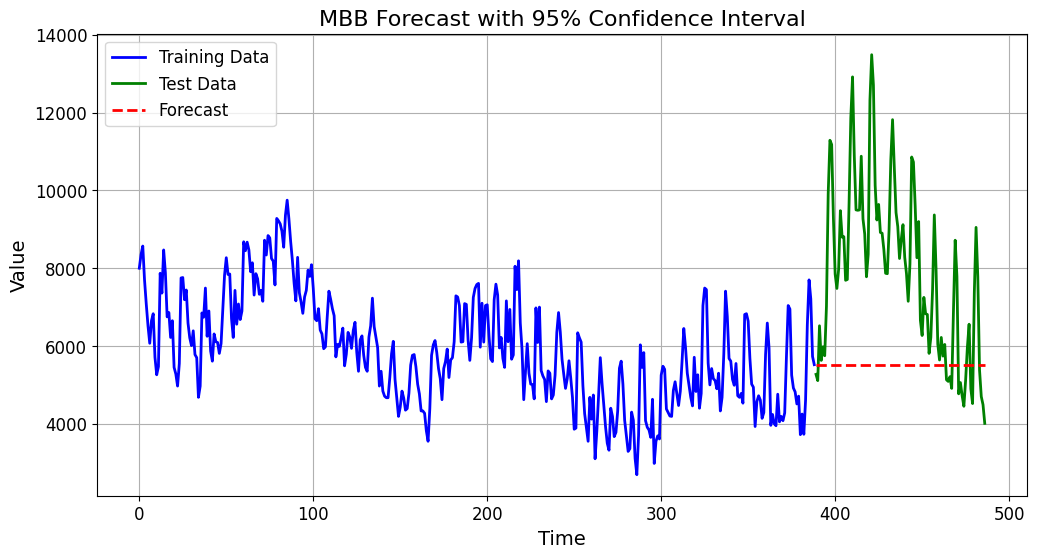

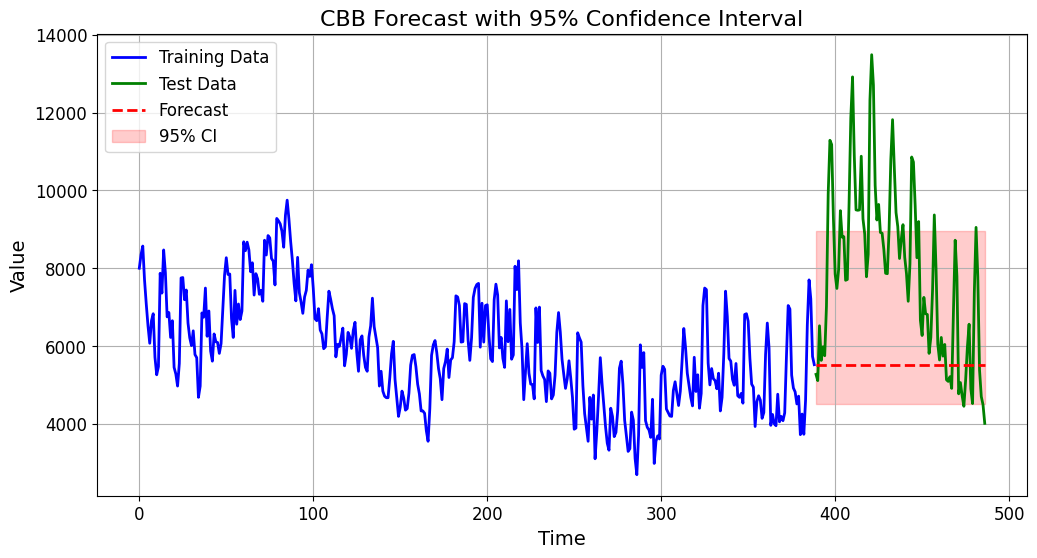

In [50]:
import matplotlib.pyplot as plt
import numpy as np


def plot_forecast_with_ci(train, test, forecast, lower_ci, upper_ci, method_name):
    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(range(len(train)), train, label='Training Data', color='blue')

    # Plot test data
    plt.plot(range(len(train), len(train) + len(test)),
             test, label='Test Data', color='green')

    # Plot forecast
    forecast_range = range(len(train), len(train) + len(forecast))
    plt.plot(forecast_range, forecast, label='Forecast',
             color='red', linestyle='--')

    # Plot confidence interval
    if lower_ci is not None and upper_ci is not None:
        plt.fill_between(forecast_range, lower_ci, upper_ci,
                         color='red', alpha=0.2, label='95% CI')
    else:
        print(f"Warning: Confidence intervals not available for {method_name}")

    plt.title(f'{method_name} Forecast with 95% Confidence Interval')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot MBB forecast
plot_forecast_with_ci(train, test, mbb_forecast, mbb_lower, mbb_upper, 'MBB')

# Plot CBB forecast
plot_forecast_with_ci(train, test, cbb_forecast, cbb_lower, cbb_upper, 'CBB')


## 3. Hands-on with tsbootstrap

[Here, you'd include code examples and explanations for each step]

1. Load and preprocess the e-commerce sales data
2. Apply different bootstrapping methods
3. Generate sales forecasts with confidence intervals
4. Simulate marketing campaign impacts

---

## 4. Interpreting the Results

- Compare forecasts from different bootstrap methods
- Analyze the width of confidence intervals
- Assess the simulated impact of marketing campaigns

---

## 5. Exercises

1. Forecast Challenge:
   - Use the provided dataset to forecast sales for the next 6 months
   - Apply at least two different bootstrapping methods
   - Compare the results and explain any differences

2. Marketing Impact Simulation:
   - Simulate a 20% increase in marketing budget
   - Use bootstrapping to estimate the range of potential sales increases
   - Present your findings with appropriate visualizations

3. Seasonal Analysis:
   - Identify any seasonal patterns in the sales data
   - Use an appropriate bootstrapping method to preserve these patterns
   - Generate a full year of simulated sales data

---

## Conclusion

Congratulations! You've now mastered time series bootstrapping techniques that will significantly improve your e-commerce sales forecasting. Remember:
- Bootstrapping provides robust uncertainty estimates
- Different methods suit different aspects of your data
- Always interpret results in the context of your business

Next steps:
- Apply these techniques to your own datasets
- Explore advanced features of tsbootstrap
- Integrate bootstrapping into your regular forecasting workflow

Happy forecasting!

## 3. Basic Concepts and Components


In [5]:
from tsbootstrap import (
    MovingBlockBootstrap,
    CircularBlockBootstrap,
    StationaryBlockBootstrap,
    NonOverlappingBlockBootstrap,
    BartlettsBootstrap,
)
import numpy as np
import matplotlib.pyplot as plt
from sktime.datasets import load_airline

### Base bootstrap classes

`tsbootstrap` provides abstract base classes for different types of bootstraps:


In [3]:
from tsbootstrap.base_bootstrap import BaseTimeSeriesBootstrap
from tsbootstrap.block_bootstrap import BlockBootstrap

In [5]:
print(
    f"MovingBlockBootstrap is a subclass of BlockBootstrap: {issubclass(MovingBlockBootstrap, BlockBootstrap)}")

MovingBlockBootstrap is a subclass of BlockBootstrap: True


### Block Length Sampling
Block length sampling is crucial in block bootstrapping methods. The length of the blocks determines how much of the original structure and dependencies are preserved. tsbootstrap provides various strategies for block length sampling, allowing users to choose the most appropriate method for their data.

In [6]:
# Example of block length sampling
from tsbootstrap.block_length_sampler import BlockLengthSampler

block_length_sampler = BlockLengthSampler()


In [7]:
for _ in range(5):
    sampled_block_length = block_length_sampler.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 2


Next we try the Normal distribution

In [8]:
block_length_sampler_normal = BlockLengthSampler(block_length_distribution="normal")

In [9]:
for _ in range(5):
    sampled_block_length = block_length_sampler_normal.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 1
Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 3


What happens if we start over?

In [10]:
block_length_sampler_normal = BlockLengthSampler(
    block_length_distribution="normal")
for _ in range(5):
    sampled_block_length = block_length_sampler_normal.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 2
Sampled block lengths: 3
Sampled block lengths: 2
Sampled block lengths: 3
Sampled block lengths: 3


We get different results. Let's try and fix the random number.

In [11]:
block_length_sampler_normal = BlockLengthSampler(
    block_length_distribution="normal", rng=42)
for _ in range(5):
    sampled_block_length = block_length_sampler_normal.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 2
Sampled block lengths: 1
Sampled block lengths: 3
Sampled block lengths: 3
Sampled block lengths: 1


In [12]:
block_length_sampler_normal = BlockLengthSampler(
    block_length_distribution="normal", rng=42)
for _ in range(5):
    sampled_block_length = block_length_sampler_normal.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 2
Sampled block lengths: 1
Sampled block lengths: 3
Sampled block lengths: 3
Sampled block lengths: 1


Et voila! Same sequence of repeatable results.

Let's try the Poisson distribution with `avg_block_length` of 4

In [13]:
block_length_sampler_poisson = BlockLengthSampler(avg_block_length=4, block_length_distribution="poisson", rng=42)
for _ in range(5):
    sampled_block_length = block_length_sampler_poisson.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 6
Sampled block lengths: 3
Sampled block lengths: 6
Sampled block lengths: 8
Sampled block lengths: 1


### Block Generation
Block generation involves creating blocks of consecutive data points from the original time series. These blocks are then used in the resampling process to generate new bootstrap samples. tsbootstrap supports different block generation methods, each suited for specific types of time series data.

In [18]:
from tsbootstrap.block_generator import BlockGenerator

block_generator = BlockGenerator(
    block_length_sampler=block_length_sampler, input_length=10)

### Parameters
----------
`block_length_sampler` : BlockLengthSampler
    An instance of the BlockLengthSampler class which is used to determine the length of each block.

`input_length` : Integral
    The length of the input time series.

`wrap_around_flag` : bool, optional
    A flag indicating whether to allow wrap-around in the block sampling, by default False.

`rng` : Generator, optional
    The random number generator.

`overlap_length` : Integral, optional
    ONLY USED WHEN overlap_flag IS TRUE. The length of overlap between consecutive blocks. If None, overlap_length is set to half the length of the block.
    
`min_block_length` : Integral, optional
    ONLY USED WHEN overlap_flag IS TRUE. The minimum length of a block. If None, min_block_length is set to the average block length from block_length_sampler.


In [19]:
block_generator.generate_blocks(overlap_flag=True)
# block_length was 2, hence overlap_length is set to 1 by default

[array([0, 1]),
 array([1, 2]),
 array([2, 3]),
 array([3, 4]),
 array([4, 5]),
 array([5, 6]),
 array([6, 7]),
 array([7, 8]),
 array([8, 9]),
 array([9])]

In [20]:
block_generator.generate_blocks(overlap_flag=False)

[array([0, 1]), array([2, 3]), array([4, 5]), array([6, 7]), array([8, 9])]

Let's try with the normal distribution


In [ ]:
block_length_sampler_normal = BlockGenerator(
    block_length_sampler=block_length_sampler, input_length=10)

Basic concepts and components
4.Block resampling

block bootstrap methods
1. intro
2. mbb
3. circular
4. stationary
5. nonoverlapping
6. comparison and use cases

window-based
1. intro
2. bartltts
3. blackman
...
comparison and applications

model-based
1. intro
2. residula
3. distribution
4. markov
5. sieve
6. statistic-preserving

integration with sktime
1. using tsbootstrap with sktime forecasters
2. bootstrapping forecasts

case studies
1. if time permits: m5

cutom bootstrap classes